# En este notebook se entrena la red neuronal para resolver la ecuación del calor estocástica en 1D
___

## Importar librerías

In [48]:
import sys

sys.path.append("src")
from NeuralNetwork import NeuralNetwork
import numpy as np
import pickle as pkl
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

___

## Importar el Alpha Set

In [32]:
if not os.path.exists("files/alpha_set.pkl"):
    print("Primero se tiene que crear el archivo 'files/alpha_set.pkl'")
else:
    alpha_set = pkl.load(open("files/alpha_set.pkl", "rb"))

___

## Crear dominio, función de pérdida y condición inicial

In [33]:
# Definir el dominio sobre el cual se va a trabajar
np.random.seed(97)
space_domain = np.random.normal(size=(1, 1000))[0]

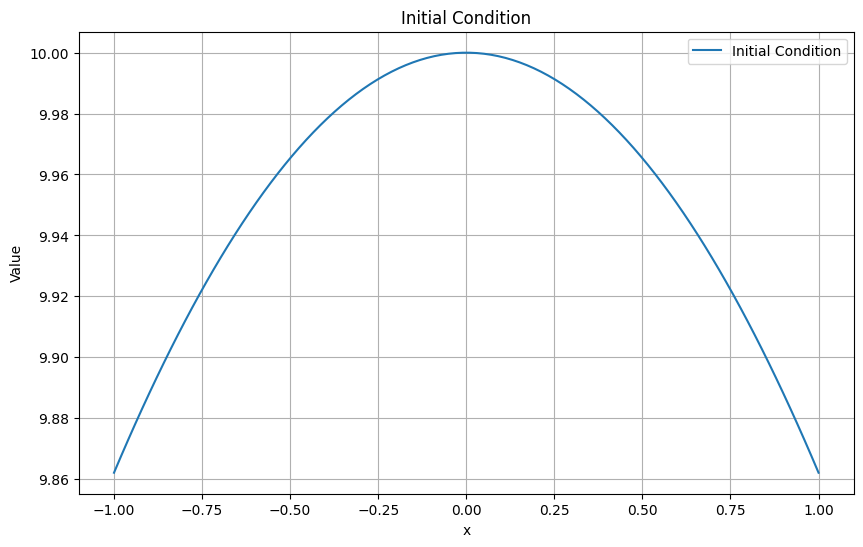

In [34]:
# Definir una condición inicial para el problema de la SPDE
def initial_condition(x):
    return 10 * np.exp(-(x**2) / 72)


# Visualizar la condición inicial
plt.figure(figsize=(10, 6))
x = np.linspace(-1, 1, 100).reshape(-1, 1)
y = initial_condition(x)
plt.plot(x, y, label="Initial Condition")
plt.title("Initial Condition")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

In [35]:
# Definir la función de pérdida para entrenar la red neuronal
def loss_function(model, space_domain, initial_condition):
    """
    Función de pérdida para entrenar la red neuronal en el contexto de una SPDE.
    Esta función calcula la pérdida basada en la ecuación estocástica parcial diferencial (SPDE) dada en el paper.
    La función de pérdida se define como la norma cuadrática del residuo de la SPDE, que se calcula a partir de los términos
    de la ecuación, incluyendo la condición inicial, el operador A, el ruido aditivo y los incrementos del movimiento Browniano.
    En particular, es la perdida para la ecuación del calor con ruido aditivo.
    Args:
        model (NeuralNetwork): La red neuronal que se está entrenando.
        space_domain (torch.Tensor): El dominio del espacio donde se evalúa la solución.
        initial_condition (function): La función que define la condición inicial del problema.
    Returns:
        torch.Tensor: El valor de la función de pérdida, que es la norma cuadrática del residuo de la SPDE.
    """
    # ---------------------------------------------------------
    # Preparación: malla temporal y espacial
    # Elección de los puntos t_{m2}, u_{m3}
    # ---------------------------------------------------------
    model.eval()

    t_interval = model.t  # malla temporal  t_{m2}
    t = torch.tensor(t_interval, dtype=torch.float32)

    dt = torch.tensor([t[1]])  # Δt  constante (malla uniforme)
    n = len(t)
    m = torch.tensor(range(1, n + 1))

    x = torch.tensor(space_domain, dtype=torch.float32)  # malla espacial u_{m3}

    # Producto cartesiano para generar Ω_t = {(t_{m2},u_{m3})}
    # Cada punto se identifica con el triple (ω_{m1}, t_{m2}, u_{m3})
    Omega_t = torch.cartesian_prod(t, x).requires_grad_()
    Omega_dt = torch.cartesian_prod(dt, x).requires_grad_()  # se usa para A X · Δt

    # ---------------------------------------------------------
    # Evaluación de X^{(I,J,K)} en los tres conjuntos
    # Término ∂^{β} X^{(I,J,K)}_{t_{m2}}(ω_{m1})(u_{m3})
    # En este caso, β=0, por lo que es X_{t_{m2}}(ω_{m1})(u_{m3})
    # ---------------------------------------------------------
    U_t = model(Omega_t)  # X_{t_{m2}}
    U_dt = model(Omega_dt)  # X_{t_{l-1}}

    # ---------------------------------------------------------
    # Operador A = ∂_{xx}  (ecuación del calor)
    # Suma  Σ_{l=1}^{m2}  A X_{t_{l-1}} · Δt
    # Se aproxima con n * (∂_{xx}X) · Δt ya que Δt = T/n
    # ---------------------------------------------------------
    Ux_dt = torch.autograd.grad(
        U_dt,
        Omega_dt,
        grad_outputs=torch.ones_like(U_dt),
        create_graph=True,
    )[0][:, 1]  # ∂_x X

    Uxx_dt = torch.autograd.grad(
        Ux_dt,
        Omega_dt,
        grad_outputs=torch.ones_like(Ux_dt),
        create_graph=True,
    )[0][:, 1]  # ∂_{xx} X    = A X

    AX_term = torch.kron(m, Uxx_dt)

    # ---------------------------------------------------------
    # Ruido aditivo  B≡1  y suma de incrementos de W
    # Σ_{l=1}^{m2} ⟨B(X_{t_{l-1}}), W_{t_l}-W_{t_{l-1}}⟩
    # Aquí la proyección en la base g_j ya está pre-computada
    # y almacenada en  brownian_increments.
    # ---------------------------------------------------------
    brownian_paths = (model.alpha_set.brownian_paths[model.omega])[0]
    paths_tensor = torch.tensor(
        brownian_paths, dtype=U_t.dtype, device=U_t.device
    )  # ⟨B(X_{t_{l-1}}), W_{t_l}-W_{t_{l-1}}⟩
    # Repetir los valores de paths_tensor a lo largo del eje espacial (hacia el lado)
    paths_tensor = paths_tensor.unsqueeze(1).repeat(1, len(space_domain)).reshape(-1)

    # ---------------------------------------------------------
    # Condición inicial  χ₀(u_{m3})
    # ---------------------------------------------------------
    initial_sol = initial_condition(x)  # χ₀(u_{m3})
    initial_sol_tensor = torch.tensor(initial_sol, dtype=U_t.dtype, device=U_t.device)
    initial_sol_tensor_expanded = initial_sol_tensor.repeat(n)

    # ---------------------------------------------------------
    # Residuo  ℓ(·)
    # ℓ = X_{t_{m2}} − χ₀ − Σ_l A X Δt − Σ_l ⟨B,ΔW⟩
    # ---------------------------------------------------------
    residual = U_t - initial_sol_tensor_expanded - AX_term - paths_tensor

    # ---------------------------------------------------------
    # Función de pérdida  L
    # L = ( Σ |ℓ|² / N )^{1/2}
    # Cada c_{β,m₁,m₂,m₃}=1, pesos uniformes y unitarios
    # ---------------------------------------------------------
    return nn.MSELoss()(residual, torch.zeros_like(U_t))

___

## Entrenar la red neuronal

In [36]:
n_layers = 1  # Número de capas ocultas
wide = 10  # Ancho de las capas ocultas
activation = nn.Tanh  # Función de activación
epochs = 10  # Número de épocas de entrenamiento
optimizer = optim.Adam  # Optimizador
lr = 0.001  # Tasa de aprendizaje

In [41]:
train = False  # True para entrenar la red, False para cargar un modelo preentrenado

In [42]:
if train:
    # Definir modelo
    nn_model = NeuralNetwork(
        space_dim=1,
        alpha_set=alpha_set,
        n_layers=n_layers,
        wide=wide,
        activation=activation,
    )

    # Entrenar el modelo
    loss_list = nn_model.train_model(
        space_domain=space_domain,
        loss_function=loss_function,
        initial_condition=initial_condition,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        model_name="heat_1d_paper_params",
    )

    # Visualizar la pérdida durante el entrenamiento
    plt.figure(figsize=(10, 6))
    plt.plot(loss_list, label="Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()

    # Guardar el modelo entrenado
    pkl.dump(nn_model, open("files/heat_1d_paper.pkl", "wb"))

In [43]:
if not train:
    # Cargar el modelo preentrenado
    if not os.path.exists("files/heat_1d_paper.pkl"):
        print("Primero se tiene que crear el archivo 'files/heat_1d_paper.pkl'")
    else:
        nn_model = pkl.load(open("files/heat_1d_paper.pkl", "rb"))
        print("Modelo cargado correctamente.")

Modelo cargado correctamente.


___

## Evaluar el modelo

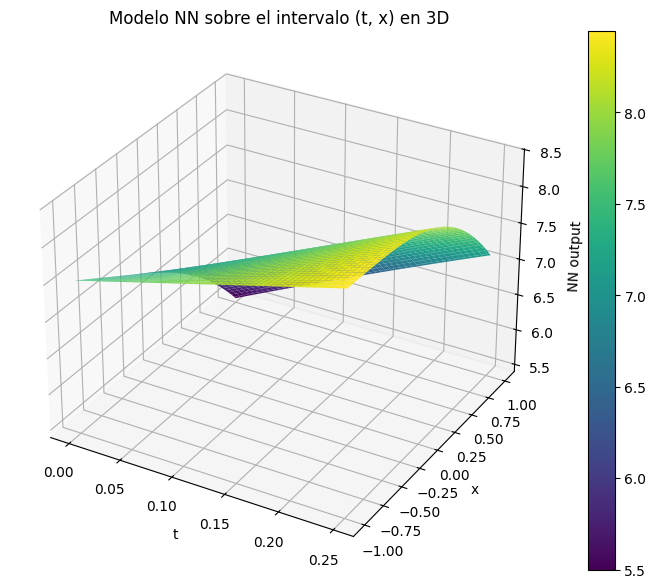

In [46]:
# Selección el omega para evaluar la red neuronal
nn_model.omega = 3

# Crear la grilla de puntos (t, x) para evaluar la red neuronal
t_points = np.linspace(0, 0.25, 100)
x_points = np.linspace(-1, 1, 100)
t_grid, x_grid = np.meshgrid(t_points, x_points)
input_tensor = torch.tensor(
    np.stack([t_grid.ravel(), x_grid.ravel()], axis=1), dtype=torch.float32
)

# Calcular la salida de    # dt = dt.repeat(n)  # vector (Δt,…,Δt) la red neuronal
with torch.no_grad():
    output = nn_model(input_tensor).cpu().numpy().reshape(t_grid.shape)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(t_grid, x_grid, output, cmap="viridis")
fig.colorbar(surf)
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_zlabel("NN output")
ax.set_title("Modelo NN sobre el intervalo (t, x) en 3D")
plt.show()

___